# Import

In [72]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris, load_boston
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor, VotingRegressor)
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import (explained_variance_score, mean_absolute_error,
                             mean_squared_error, r2_score)
from sklearn.model_selection import (cross_validate,train_test_split)
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet
import util
import matplotlib.pyplot as plt
import pmdarima as pm

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data prep

In [3]:
train = pd.read_csv('../data/train.csv')
test  = pd.read_csv('../data/test.csv')
features = pd.read_csv('../data/features.csv')

## Store = 1 / Dept = 1

In [4]:
train.rename(columns={'Date':'ds','Weekly_Sales':'y'},inplace=True)
test.rename(columns={'Date':'ds'},inplace=True)

In [5]:
train2 = train[train['Store']==1]
train2 = train2[train2['Dept']==1]
train2 = train2.sort_values('ds')

In [6]:
train2['ds'] = pd.to_datetime(train2['ds'])
train2['ts_idx'] = train2['ds']
train2.set_index('ts_idx',inplace=True)
train2

,Store,Dept,ds,y,IsHoliday
ts_idx,,,,,
2010-02-05,1,1,2010-02-05,24924.50,False
2010-02-12,1,1,2010-02-12,46039.49,True
2010-02-19,1,1,2010-02-19,41595.55,False
2010-02-26,1,1,2010-02-26,19403.54,False
2010-03-05,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
2012-09-28,1,1,2012-09-28,18947.81,False
2012-10-05,1,1,2012-10-05,21904.47,False
2012-10-12,1,1,2012-10-12,22764.01,False


In [7]:
features = features[features['Store']==1]
features = features.fillna(0)
features.rename(columns={'Date':'ds'},inplace=True)
features.drop(columns=['Store'],inplace=True)

In [8]:
features['ds'] = pd.to_datetime(features['ds'])
features['ts_idx'] = features['ds']
features.set_index('ts_idx',inplace=True)
features['IsHoliday'] = features['IsHoliday'].astype(int)

In [9]:
feature_cols = features.columns.to_list()
feature_cols.remove('ds')

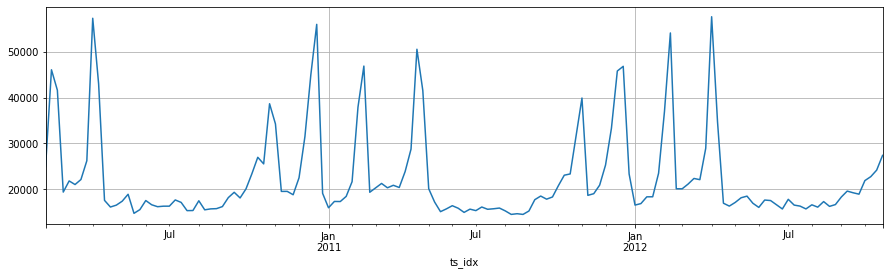

In [10]:
util.plot_sample(train2,'y')

In [11]:
train2.drop(columns=['Store','Dept','IsHoliday'],inplace=True)

In [12]:
for i in feature_cols:
    train2[i] = features[i]

In [13]:
train_col = train2.columns.to_list()
train_col.remove('ds')
train_col.remove('y')

In [14]:
df_X = train2[train_col]
df_y = train2['y']

In [15]:
split_point = int(train2.shape[0]*0.8)
df_X_train = df_X[:split_point]
df_X_test  = df_X[split_point:]
df_y_train = df_y[:split_point]
df_y_test  = df_y[split_point:]

In [16]:
df_X_train.shape, df_X_test.shape

((114, 10), (29, 10))

## Scaling

In [19]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [20]:
x_train_scaled = scaler_x.fit_transform(df_X_train.to_numpy())
x_test_scaled  = scaler_x.fit_transform(df_X_test.to_numpy())
y_train_scaled = scaler_y.fit_transform(df_y_train.to_frame().to_numpy())
y_test_scaled  = scaler_y.fit_transform(df_y_test.to_frame().to_numpy())

# Models

## Prophet

In [36]:
prophet_df = train2[['ds','y']].copy()
prophet_df_train = prophet_df[:split_point]
prophet_df_test = prophet_df[split_point:]
prophet_df_train['y'] = y_train_scaled
prophet_df_test['y'] = y_test_scaled

In [42]:
m_prophet = Prophet()

In [43]:
m_prophet.fit(prophet_df_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
forecast = m_prophet.predict(prophet_df_test)

In [45]:
forecast = forecast[['ds','yhat']]
forecast.rename(columns={'yhat':'y'},inplace=True)
forecast.set_index('ds',inplace=True)

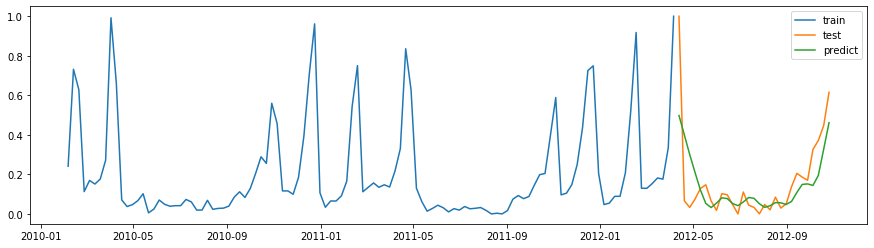

In [46]:
util.plot_comparison(prophet_df_train, prophet_df_test, forecast)

## Arima

In [47]:
PERIOD=52
m_arima = pm.auto_arima(
        y=y_train_scaled,
        exogenous=None,
        start_p=2,
        d=None,
        start_q=2,
        max_p=5,
        max_d=2,
        max_q=5,
        start_P=1,
        D=None,
        start_Q=1,
        max_P=2,
        max_D=1,
        max_Q=2,
        max_order=5,
        m=PERIOD,  # default: 1, The period for seasonal differencing
        seasonal=True,
        stationary=False,
        information_criterion='aic',
        alpha=0.05,
        test='kpss',
        seasonal_test='ocsb',
    # --------------------
    # stepwise : bool, optional (default=True)
    #     Whether to use the stepwise algorithm outlined in Hyndman and Khandakar
    #     (2008) to identify the optimal model parameters. The stepwise algorithm
    #     can be significantly faster than fitting all (or a ``random`` subset
    #     of) hyper-parameter combinations and is less likely to over-fit
    #     the model
    # for random search; stepwise=False, n_jobs=-1, random=True
        maxiter=500, # default 50
        n_jobs=-1, # Default is 1, but -1 can be used to designate "as many as possible"
        stepwise=True,
        random=False, # default: False, random search
        n_fits=10,   # default: 10, If ``random`` is True and a "random search" is going to be performed, ``n_iter`` is the number of ARIMA models to be fit.
    # --------------------
        start_params=None,
        trend=None,
        method='lbfgs',
        offset_test_args=None,
        seasonal_test_args=None,
        suppress_warnings=False,
        error_action='warn',
        trace=False,
        random_state=0,  # default: None
        return_valid_fits=False,
        out_of_sample_size=0,
        scoring='mse',
        scoring_args=None,
        with_intercept=True,
        sarimax_kwargs=None,
    )

C:\anaconda\lib\site-packages\pmdarima\arima\auto.py:303: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)
C:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWar

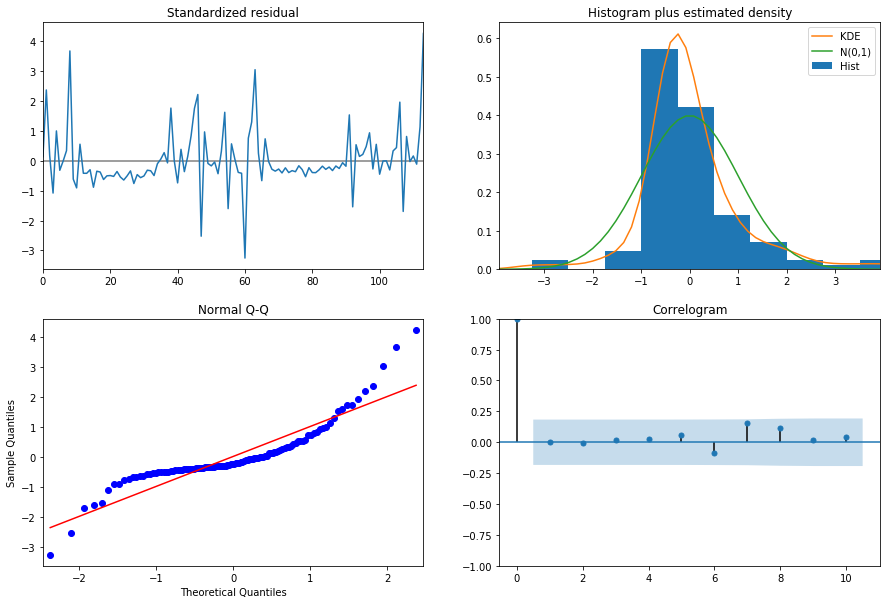

In [48]:
fig = m_arima.plot_diagnostics(figsize=(15,10))

In [49]:
y_pred_arima = m_arima.predict(n_periods=y_test_scaled.shape[0])

In [50]:
y_pred_arima

array([0.81825663, 0.70265854, 0.34197159, 0.02267033, 0.06147755,
       0.09694473, 0.12479116, 0.12405052, 0.1005381 , 0.07972079,
       0.08997617, 0.08841236, 0.10204505, 0.09549128, 0.09666233,
       0.09835125, 0.08904376, 0.07815218, 0.08042371, 0.07831074,
       0.08900948, 0.12464236, 0.13601012, 0.1262397 , 0.13314729,
       0.16866488, 0.20158335, 0.20554314, 0.3243308 ])

In [83]:
result = forecast.copy()
result.rename(columns={'y':'prophet'},inplace=True)

In [84]:
result['arima'] = y_pred_arima

In [86]:
result['test'] = y_test_scaled

## RandomForest

In [54]:
# ?RandomForestRegressor
m_rf = RandomForestRegressor(n_estimators=1000,
                              criterion='mse',
                              max_depth=None,
                              min_samples_split=2,
                              min_samples_leaf=1,
                              min_weight_fraction_leaf=0.,
                              max_features='auto',
                              random_state=0)

In [55]:
_ = m_rf.fit(x_train_scaled, y_train_scaled)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [61]:
util.report_feature_importance(feature_cols, m_rf.feature_importances_)

Variable: Temperature          Importance: 0.45
Variable: Fuel_Price           Importance: 0.17
Variable: CPI                  Importance: 0.17
Variable: Unemployment         Importance: 0.06
Variable: MarkDown4            Importance: 0.05
Variable: MarkDown2            Importance: 0.03
Variable: MarkDown3            Importance: 0.03
Variable: MarkDown1            Importance: 0.01
Variable: MarkDown5            Importance: 0.01
Variable: IsHoliday            Importance: 0.01


## GradientBoost

In [63]:
# ?GradientBoostingRegressor
m_gb = GradientBoostingRegressor(
    loss='ls',
    learning_rate=0.001,  #default 0.1
    n_estimators=1000,  #default 100
    subsample=1.0,
    criterion='friedman_mse',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    init=None,
    random_state=0,
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    presort='deprecated',
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0,
)

In [64]:
_ = m_gb.fit(x_train_scaled, y_train_scaled)

C:\anaconda\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
util.report_feature_importance(feature_cols, m_gb.feature_importances_)

Variable: Temperature          Importance: 0.6
Variable: CPI                  Importance: 0.14
Variable: Fuel_Price           Importance: 0.08
Variable: MarkDown4            Importance: 0.06
Variable: Unemployment         Importance: 0.05
Variable: MarkDown5            Importance: 0.04
Variable: MarkDown2            Importance: 0.02
Variable: MarkDown3            Importance: 0.01
Variable: MarkDown1            Importance: 0.0
Variable: IsHoliday            Importance: 0.0


## XGBoost

In [74]:
# ?XGBRegressor
m_xgb = XGBRegressor(
    max_depth=6,  #default 3
    learning_rate=0.001,  #default 0.1
    n_estimators=1000,  #default 100
    verbosity=1,
    objective='reg:squarederror',
    booster='gbtree',
    n_jobs=5,  #default 1
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    missing=None,
    importance_type='gain',
)

In [75]:
_ = m_xgb.fit(x_train_scaled, y_train_scaled)

## LGBM

In [76]:
# ?LGBMRegressor
m_lgbm = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.001,  #default 0.1
    n_estimators=1000,  #default 100
    subsample_for_bin=200000,
    objective=None,
    class_weight=None,
    min_split_gain=0.0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=0,
    n_jobs=-1,
    silent=True,
    importance_type='split',
)

In [77]:
_ = m_lgbm.fit(x_train_scaled, y_train_scaled)

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## VotingRegressor

In [80]:
regressors = [
    ('rf', m_rf),
    ('gb', m_gb),
    ('xgb', m_xgb),
    ('lgbm', m_lgbm),
]

In [82]:
m_vr1 = VotingRegressor(estimators=regressors)
_ = m_vr1.fit(x_train_scaled, y_train_scaled)

C:\anaconda\lib\site-packages\sklearn\ensemble\_voting.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Ridge

In [78]:
m_rg = Ridge(random_state=0)

In [79]:
_ = m_rg.fit(x_train_scaled, y_train_scaled)